<a href="https://colab.research.google.com/github/BATTY10/-tutorials_workflow_demo/blob/main/Practice_Excercise_Week2_%2BStandardized_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German Credit Analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Context
When a bank receives a loan application, based on the applicant’s profile the bank has to decide whether to go ahead with the loan approval or not. Two types of risks are associated with the bank’s decision –
* If the applicant is a good credit risk, i.e. is likely to repay the loan, then not approving the loan to the person results in a loss of business to the bank
* If the applicant is a bad credit risk, i.e. is not likely to repay the loan, then approving the loan to the person results in a financial loss to the bank

To minimize this loss HRE bank wants to automate this process using a predictive model, that will predict if a customer is at risk of making a default or not based on the customer’s demographic and socio-economic profiles

You as a Data scientist at HRE bank has been assigned the work of building a predictive model that will predict if a customer is at risk of default or not




### Objective 
The objective is to build a model to predict whether a person would default or not. In this dataset, the target variable is 'Risk'.

### Dataset Description
- Age (Numeric: Age in years)
- Sex (Categories: male, female)
- Job (Categories : 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (Categories: own, rent, or free)
- Saving accounts (Categories: little, moderate, quite rich, rich)
- Checking account (Categories: little, moderate, rich)
- Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
- Duration (Numeric: Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))

## Importing libraries

In [ ]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

## Loading Data

In [ ]:
# Loading the dataset
german = pd.read_csv("German_Credit.csv")

In [ ]:
# Checking the number of rows and columns in the data
german.shape

(1000, 10)

## Data Overview

In [ ]:
data = german.copy()

In [ ]:
# let's view the first 5 rows of the data
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [ ]:
# let's view the last 5 rows of the data
data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,0
996,40,male,3,own,little,little,3857,30,car,0
997,38,male,2,own,little,NaN,804,12,radio/TV,0
998,23,male,2,free,little,little,1845,45,radio/TV,1
999,27,male,2,own,moderate,moderate,4576,45,car,0


In [ ]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


- There are a total of 10 columns and 1,000 observations in the dataset
- We can see that 2 columns have less than 1,000 non-null values i.e. columns have missing values.

In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

In [ ]:
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Saving accounts    18.300
Checking account   39.400
Credit amount       0.000
Duration            0.000
Purpose             0.000
Risk                0.000
dtype: float64

- `Saving accounts` column has 18.3% missing values out of the total observations.
- `Checking account` column has 39.4% missing values out of the total observations.
-  We will impute these values after splitting the data into train,validation and test sets.

In [ ]:
# Checking for the null value in the dataset
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

**Let's check the number of unique values in each column**

In [ ]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

- Age has only 53 unique values i.e. most of the customers are of similar age
- We have only three continuous variables - Age, Credit Amount and Duration.
- All other variables are categorical

In [ ]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.000,35.546,11.375,19.000,27.000,33.000,42.000,75.000
Job,1000.000,1.904,0.654,0.000,2.000,2.000,2.000,3.000
Credit amount,1000.000,3271.258,2822.737,250.000,1365.500,2319.500,3972.250,18424.000
Duration,1000.000,20.903,12.059,4.000,12.000,18.000,24.000,72.000
Risk,1000.000,0.300,0.458,0.000,0.000,0.000,1.000,1.000


- Mean value for the age column is approx 35 and the median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range of 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.

**Checking the value count for each category of categorical variables** 

In [ ]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

male      690
female    310
Name: Sex, dtype: int64
----------------------------------------
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
----------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
----------------------------------------
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
----------------------------------------
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
----------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
----------------------------------------
0    700
1    300
Name: Risk, dtype: int64
----------------------------------------


- We have more male customers as compared to female customers
- There are very few observations i.e. only 22 for customers with job category - unskilled and non-resident
- We can see that the distribution of classes in the target variable is imbalanced i.e. only 30% observations with defaulters.

## Univariate analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Observation on Age 

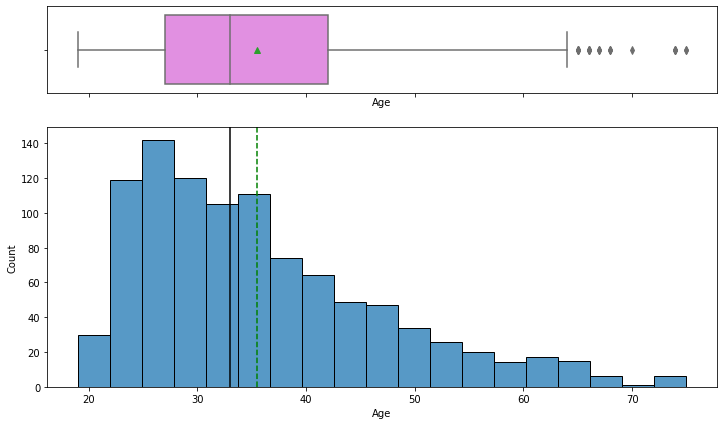

In [ ]:
# Observations on Customer_age
histogram_boxplot(data, "Age")

- The distribution of age is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observation on Credit Amount

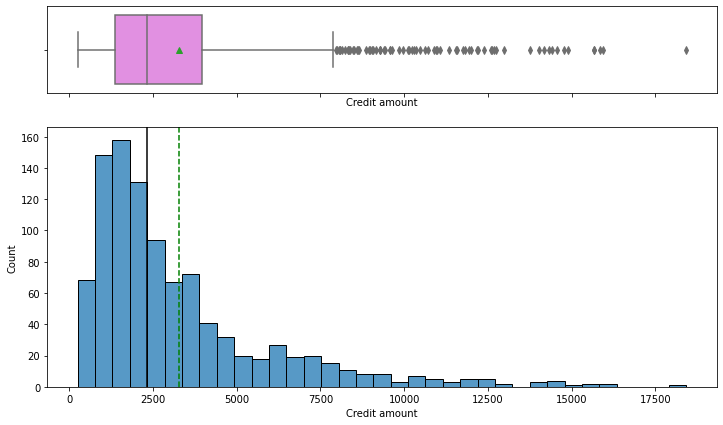

In [ ]:
histogram_boxplot(data, "Credit amount")

- The distribution of the credit amount is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observations on Duration

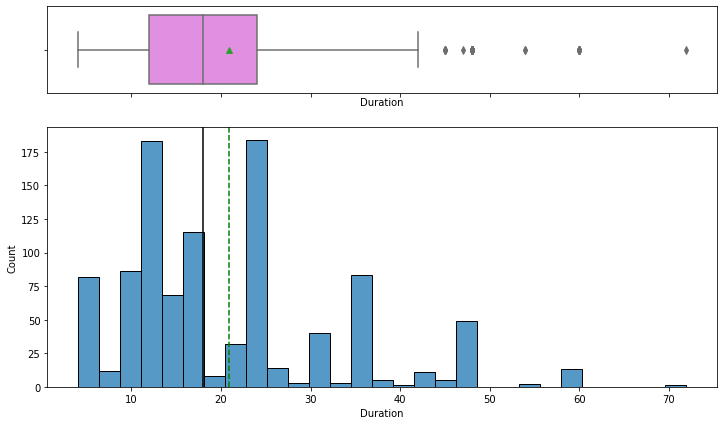

In [ ]:
histogram_boxplot(data, "Duration")

- The distribution of the duration for which the credit is given is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Observations on Risk

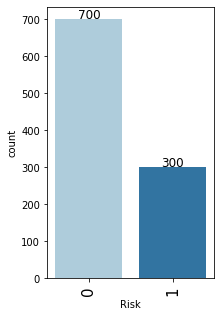

In [ ]:
# observations on Risk
labeled_barplot(data, "Risk")

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 70% observations for non-defaulters and 30% observations for defaulters.

### Observations on Sex of Customers

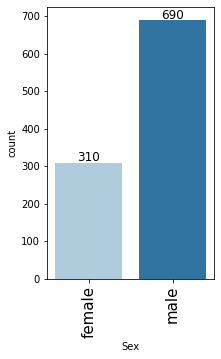

In [ ]:
# observations on Sex
labeled_barplot(data, "Sex")

- Male customers are taking more credit than female customers
- There are approx 69% male customers and  31% are the female customers

### Observations on Housing

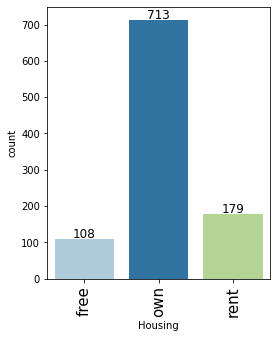

In [ ]:
# observations on Housing
labeled_barplot(data, "Housing")

- Major of the customers, approx 71%, who take credit have their own house
- Approx 18% of customers are living in a rented house
- There are only 11% of customers who have free housing. These are the customers who live in a house given by their company or organization

### Observations on Job

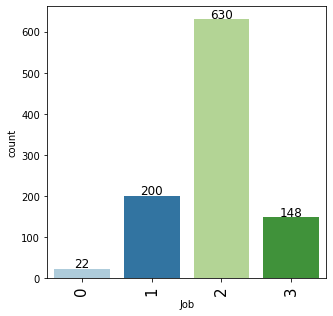

In [ ]:
# observations on Job
labeled_barplot(data, "Job")

- Majority of the customers i.e. 63% fall into the skilled category.
- There are only approx 15% of customers that lie in the highly skilled category which makes sense as these may be the persons with high education or highly experienced.
- There are very few observations, approx 22%, with 0 or 1 job category.

### Observations on Saving accounts

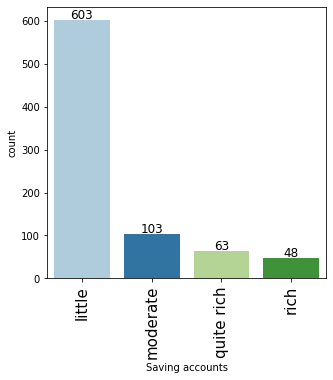

In [ ]:
# observations on Saving accounts
labeled_barplot(data, "Saving accounts")

- Approx 70% of customers who take credit have a little or moderate amount in their savings account. This makes sense as these customers would need credit more than the other categories.
- Approx 11% of customers who take credit are in a rich category based on their balance in the savings account.
- Note that the percentages do not add up to 100 as we have missing values in this column.

### Observations on Checking account

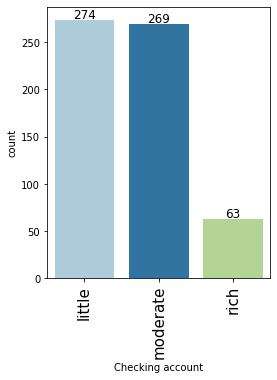

In [ ]:
# observations on Checking account
labeled_barplot(data, "Checking account")

- Approx 54% of customers who take credit have a little or moderate amount in their checking account. This makes sense as these customers would need credit more than the other categories.
- Approx 6% of customers who take credit are in the rich category based on their balance in checking account.
- Note that the percentages do not add up to 100 as we have missing values in this column.

### Observations on Purpose

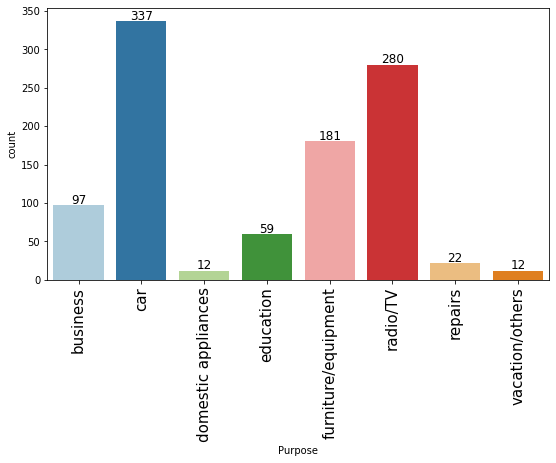

In [ ]:
# observations on Purpose
labeled_barplot(data, "Purpose")

- The plot shows that most customers take credit for luxury items like cars, radio or furniture/equipment, domestic appliances.
- Approximately just 16% of customers take credit for business or education

## Bivariate Analysis

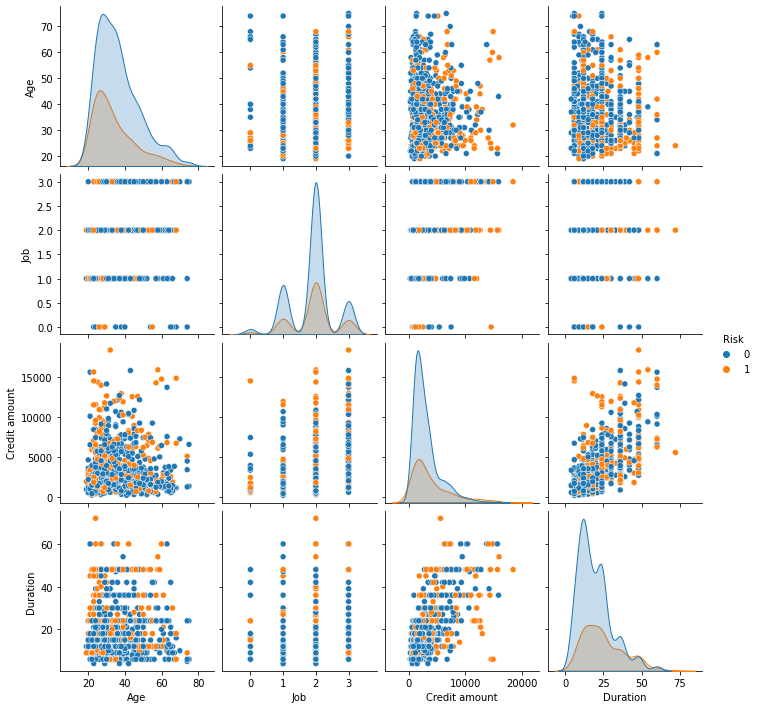

In [ ]:
sns.pairplot(data, hue="Risk")

- There are overlaps i.e. no clear distinction in the distribution of variables for people who have defaulted and did not default.
- Let's explore this further with the help of other plots.

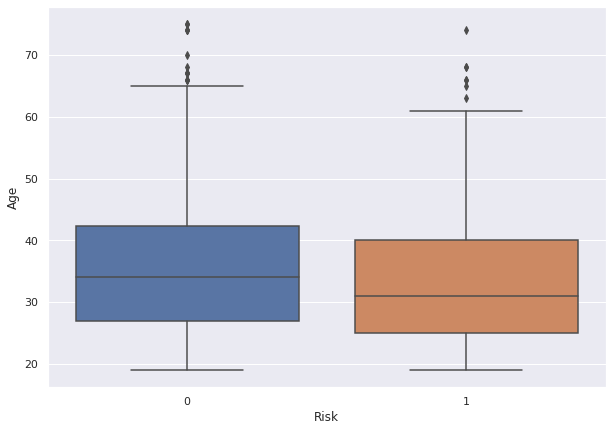

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Age", data=data, orient="vertical")

- We can see that the median age of defaulters is less than the median age of non-defaulters.
- This shows that younger customers are more likely to default.
- There are outliers in boxplots of both class distributions

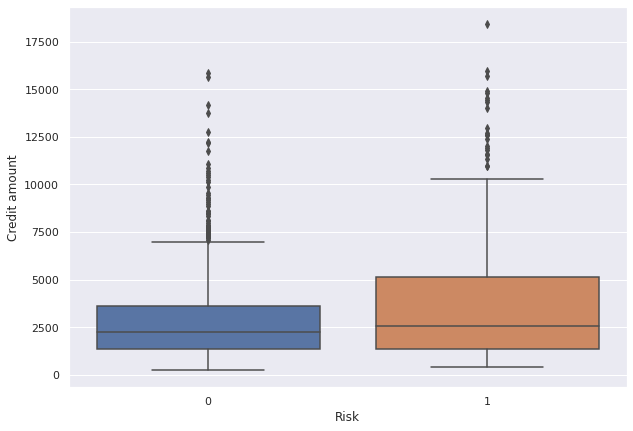

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Credit amount", data=data, orient="vertical")

- We can see that the third quartile amount of defaulters is much more than the third quartile amount of non-defaulters.
- This shows that customers with high credit amounts are more likely to default.
- There are outliers in boxplots of both class distributions

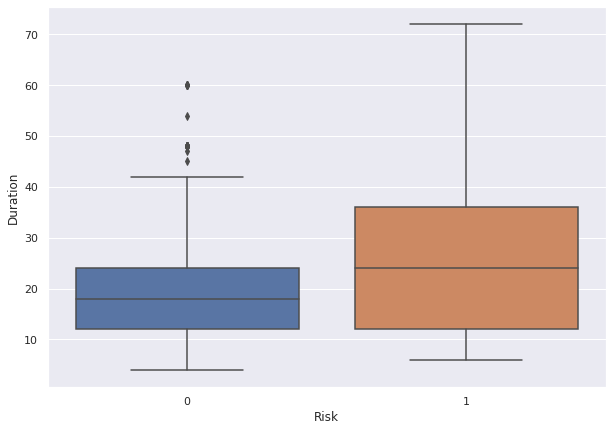

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Duration", data=data, orient="vertical")

- We can see that the second and third quartile duration of defaulters is much more than the second and third quartile duration of non-defaulters.
- This shows that customers with high duration are more likely to default.

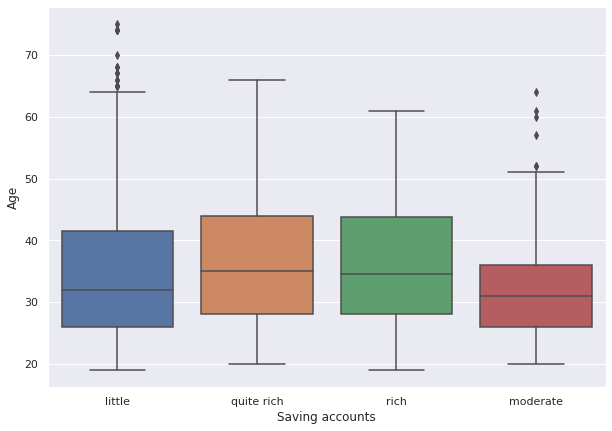

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Saving accounts", y="Age", data=data)

- The plot shows that customers with higher age are in the rich or quite rich category.
- Age of the customers in the little and moderate category is slightly less but there are outliers in both of the distributions.

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Risk      0    1   All
Sex                   
All     700  300  1000
male    499  191   690
female  201  109   310
------------------------------------------------------------------------------------------------------------------------


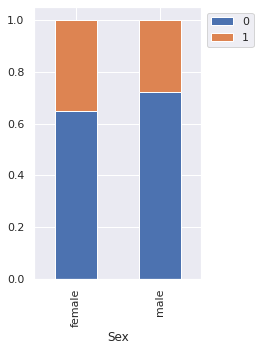

In [ ]:
stacked_barplot(data, "Sex", "Risk")

- We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.

Risk    0    1   All
Job                 
All   700  300  1000
2     444  186   630
1     144   56   200
3      97   51   148
0      15    7    22
------------------------------------------------------------------------------------------------------------------------


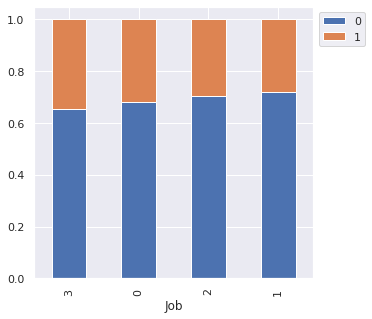

In [ ]:
stacked_barplot(data, "Job", "Risk")

- There is no significant difference concerning the job level
- However, highly skilled or unskilled/non-resident customers are more likely to default as compared to customers in 1 or 2 category 

Risk       0    1   All
Housing                
All      700  300  1000
own      527  186   713
rent     109   70   179
free      64   44   108
------------------------------------------------------------------------------------------------------------------------


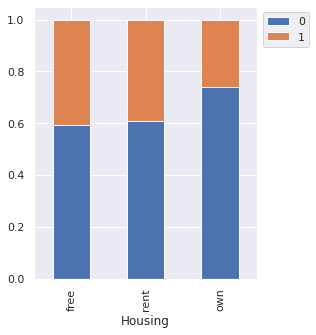

In [ ]:
stacked_barplot(data, "Housing", "Risk")

- Customers owning a house are less likely to default
- Customers with free or rented housing are almost at the same risk of default

Risk               0    1  All
Saving accounts               
All              549  268  817
little           386  217  603
moderate          69   34  103
quite rich        52   11   63
rich              42    6   48
------------------------------------------------------------------------------------------------------------------------


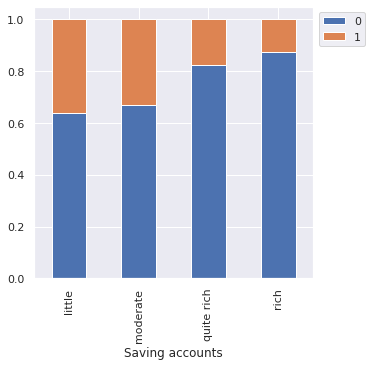

In [ ]:
stacked_barplot(data, "Saving accounts", "Risk")

- As we saw earlier, customers with a little or moderate amount in saving accounts take more credit but at the same time, they are most likely to default.
- Rich customers are slightly less likely to default as compared to quite rich customers

Risk                0    1  All
Checking account               
All               352  254  606
little            139  135  274
moderate          164  105  269
rich               49   14   63
------------------------------------------------------------------------------------------------------------------------


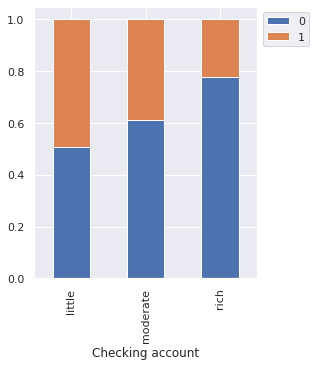

In [ ]:
stacked_barplot(data, "Checking account", "Risk")

- The plot further confirms the findings of the plot above.
- Customers with a little amount in checking accounts are most likely to default as compared to customers with a moderate amount, which in turn, are more likely as compared to the rich customers.

Risk                   0    1   All
Purpose                            
All                  700  300  1000
car                  231  106   337
radio/TV             218   62   280
furniture/equipment  123   58   181
business              63   34    97
education             36   23    59
repairs               14    8    22
vacation/others        7    5    12
domestic appliances    8    4    12
------------------------------------------------------------------------------------------------------------------------


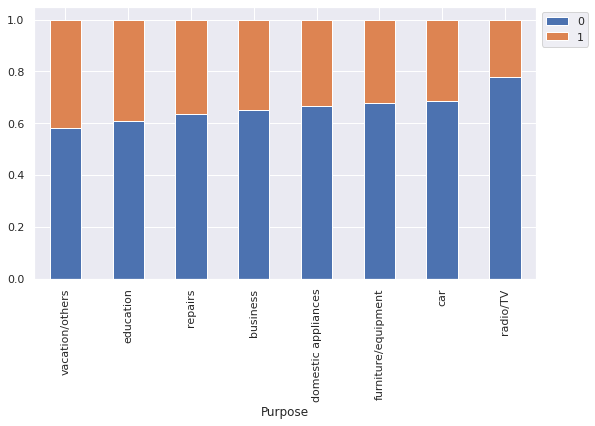

In [ ]:
stacked_barplot(data, "Purpose", "Risk")

- Customers who take credit for radio/TV are least likely to default. This might be because their credit amount is small.
- Customers who take credit for education or vacation are most likely to default.
- Other categories have no significant difference between their default and non-default ratio.

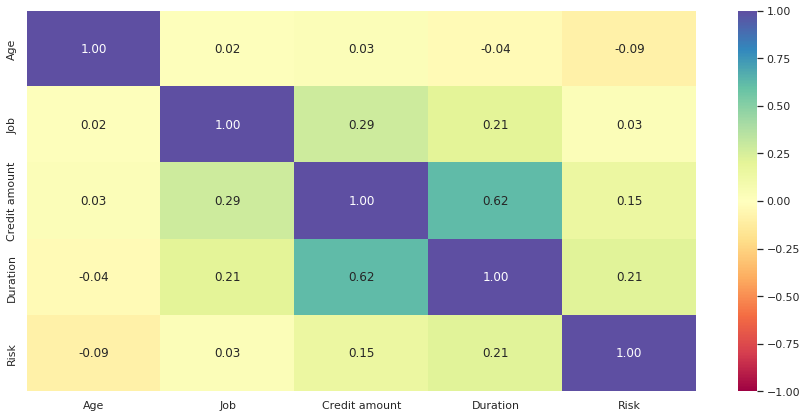

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- Credit amount and duration have a positive correlation which makes sense as customers might take the credit for a longer duration if the amount of credit is high
- Other variables have no significant correlation between them

### Data Preparation for Modeling

### Split data

In [ ]:
df = data.copy()

In [ ]:
X = df.drop(["Risk"], axis=1)
y = df["Risk"]

In [ ]:
# Splitting data into training, validation and test sets:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(600, 9) (200, 9) (200, 9)


### Missing-Value Treatment

* We will use mode to impute missing values in Saving accounts and Checking account column.

In [ ]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cols_to_impute = ["Saving accounts", "Checking account"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

In [ ]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_val = pd.get_dummies(data=X_val, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

### Model evaluation criterion

### We will be using Recall as a metric for our model performance because here company could face 2 types of losses
1. Could Give loan to defaulters - Loss of money
2. Not give Loan to non-defaulters - Loss of opportunity

### Which Loss is greater? 
* Giving loan to defaulters i.e Predicting a person not at risk, while actually person is at risk of making a default. 

### How to reduce this loss i.e need to reduce False Negatives?
* Company wants recall to be maximized i.e. we need to reduce the number of false negatives.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Bagging: 24.444444444444446
Random forest: 24.444444444444446
GBM: 25.0
Adaboost: 25.0
Xgboost: 27.222222222222225
dtree: 43.33333333333333

Validation Performance:

Bagging: 0.2833333333333333
Random forest: 0.31666666666666665
GBM: 0.31666666666666665
Adaboost: 0.26666666666666666
Xgboost: 0.26666666666666666
dtree: 0.31666666666666665


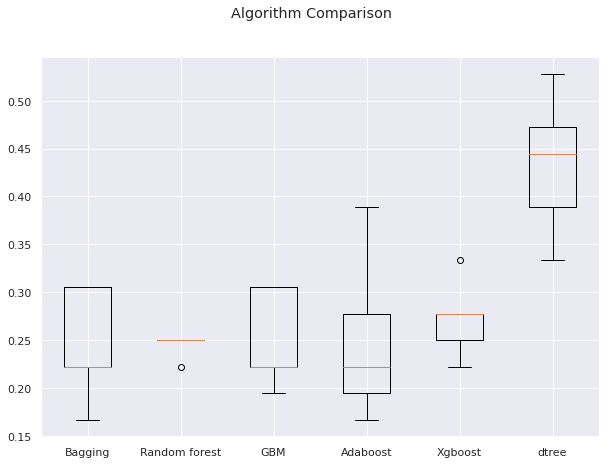

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that the decision tree is giving the highest cross-validated recall followed by xgboost
- The boxplot shows that the performance of decision tree and xgboost is consistent and their performance on the validation set is also good
- We will tune the best two models i.e. decision tree and xgboost and see if the performance improves 

# Hyperparameter Tuning
**We will tune decision tree and xgboost models using GridSearchCV and RandomizedSearchCV. We will also compare the performance and time taken by these two methods - grid search and randomized search.**

**First let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree

### GridSearchCV

In [ ]:
# Creating pipeline
model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5, None],
    "min_samples_split": [2, 4, 7, 10, 15],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2} 
Score: 0.40555555555555556


In [ ]:
# Creating new pipeline with best parameters
dtree_tuned1 = DecisionTreeClassifier(
    random_state=1, criterion="gini", max_depth=None, min_samples_split=2
)

# Fit the model on training data
dtree_tuned1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_grid_train = model_performance_classification_sklearn(
    dtree_tuned1, X_train, y_train
)
print("Training performance:")
dtree_grid_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
dtree_grid_val = model_performance_classification_sklearn(dtree_tuned1, X_val, y_val)
print("Validation performance:")
dtree_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.595,0.317,0.322,0.319


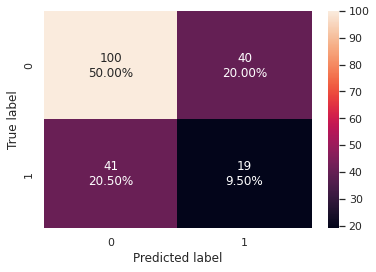

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(dtree_tuned1, X_val, y_val)

- The validation recall has same performance to the validation recall on model with default parameters
- The tuned decision tree model is overfitting the training data
- The validation recall is still just ~31% i.e. the model is not good at identifying defaulters

### RandomizedSearchCV

In [ ]:
# Creating pipeline
model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5, None],
    "min_samples_split": [2, 4, 7, 10, 15],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy'} with CV score=0.36666666666666664:


In [ ]:
# Creating new pipeline with best parameters
dtree_tuned2 = DecisionTreeClassifier(
    random_state=1, criterion="entropy", max_depth=None, min_samples_split=2
)

# Fit the model on training data
dtree_tuned2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_random_train = model_performance_classification_sklearn(
    dtree_tuned2, X_train, y_train
)
print("Training performance:")
dtree_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
dtree_random_val = model_performance_classification_sklearn(dtree_tuned2, X_val, y_val)
print("Validation performance:")
dtree_random_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.575,0.450,0.342,0.388


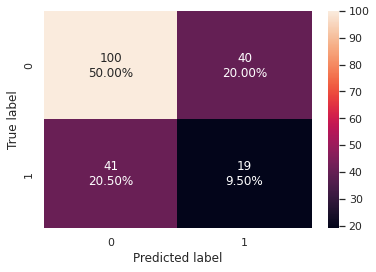

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(dtree_tuned1, X_val, y_val)

- We reduced the number of iterations to only 20 but two out of the three parameters are the same as what we got from the grid search. 
- The validation recall has increased by ~14% as compared to cross-validated recall
- The recall and accuracy are slightly less but still similar to the results for the decision tree model tuned with GridSearchCV is overfitting the training data

## XGBoost

### GridSearchCV

In [ ]:
%%time 

#defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in GridSearchCV
param_grid={'n_estimators':np.arange(50,150,50),
            'scale_pos_weight':[2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSeachCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Best parameters are {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50, 'reg_lambda': 5, 'scale_pos_weight': 10, 'subsample': 0.8} with CV score=1.0:
CPU times: user 21.4 s, sys: 510 ms, total: 21.9 s
Wall time: 5min 53s


In [ ]:
# building model with best parameters
xgb_tuned1 = XGBClassifier(
    random_state=1,
    n_estimators=50,
    scale_pos_weight=10,
    subsample=0.8,
    learning_rate=0.01,
    gamma=0,
    eval_metric="logloss",
    reg_lambda=5,
    max_depth=1,
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', learning_rate=0.01, max_depth=1,
              n_estimators=50, random_state=1, reg_lambda=5,
              scale_pos_weight=10, subsample=0.8)

In [ ]:
# Calculating different metrics on train set
xgboost_grid_train = model_performance_classification_sklearn(
    xgb_tuned1, X_train, y_train
)
print("Training performance:")
xgboost_grid_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.300,1.000,0.300,0.462


In [ ]:
# Calculating different metrics on validation set
xgboost_grid_val = model_performance_classification_sklearn(xgb_tuned1, X_val, y_val)
print("Validation performance:")
xgboost_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.300,1.000,0.300,0.462


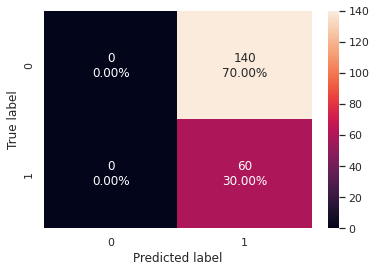

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_val, y_val)

- The validation recall has increased by ~65% as compared to the result from cross-validation with default parameters.
- The model is giving a generalized performance.
- The model can identify most of the defaulters

### RandomizedSearchCV

In [ ]:
%%time

# defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={'n_estimators':np.arange(50,150,50),
            'scale_pos_weight':[2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
xgb_tuned2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned2.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned2.best_params_,xgb_tuned2.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'reg_lambda': 5, 'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.01, 'gamma': 1} with CV score=1.0:
CPU times: user 687 ms, sys: 21.7 ms, total: 708 ms
Wall time: 7.4 s


In [ ]:
# building model with best parameters
xgb_tuned2 = XGBClassifier(
    random_state=1,
    n_estimators=50,
    scale_pos_weight=10,
    gamma=1,
    subsample=0.9,
    learning_rate=0.01,
    eval_metric="logloss",
    max_depth=1,
    reg_lambda=5,
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', gamma=1, learning_rate=0.01, max_depth=1,
              n_estimators=50, random_state=1, reg_lambda=5,
              scale_pos_weight=10, subsample=0.9)

In [ ]:
# Calculating different metrics on train set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned2, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.300,1.000,0.300,0.462


In [ ]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned2, X_val, y_val)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.300,1.000,0.300,0.462


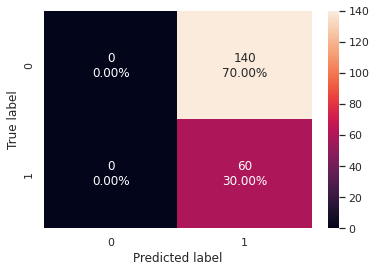

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned2, X_val, y_val)

- We reduced the number of iterations to only 20 but the model performance is very similar to the results for the xgboost model tuned with GridSearchCV

### Comparing models from GridsearchCV and RandomisedsearchCV

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        dtree_grid_train.T,
        dtree_random_train.T,
        xgboost_grid_train.T,
        xgboost_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree Tuned with Grid search",
    "Decision Tree Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree Tuned with Grid search,Decision Tree Tuned with Random search,Xgboost Tuned with Grid search,Xgboost Tuned with Random Search
Accuracy,1.000,1.000,0.300,0.300
Recall,1.000,1.000,1.000,1.000
Precision,1.000,1.000,0.300,0.300
F1,1.000,1.000,0.462,0.462


In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        dtree_grid_val.T,
        dtree_random_val.T,
        xgboost_grid_val.T,
        xgboost_random_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Decision Tree Tuned with Grid search",
    "Decision Tree Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Decision Tree Tuned with Grid search,Decision Tree Tuned with Random search,Xgboost Tuned with Grid search,Xgboost Tuned with Random Search
Accuracy,0.595,0.575,0.300,0.300
Recall,0.317,0.450,1.000,1.000
Precision,0.322,0.342,0.300,0.300
F1,0.319,0.388,0.462,0.462


- We can see that XGBoost is giving a similar performance with GridSearchCV and RandomizedSearchCV with a validation recall of ~1.00
- Let's see the feature importance from the xgboost model tuned with GridSearchCV.

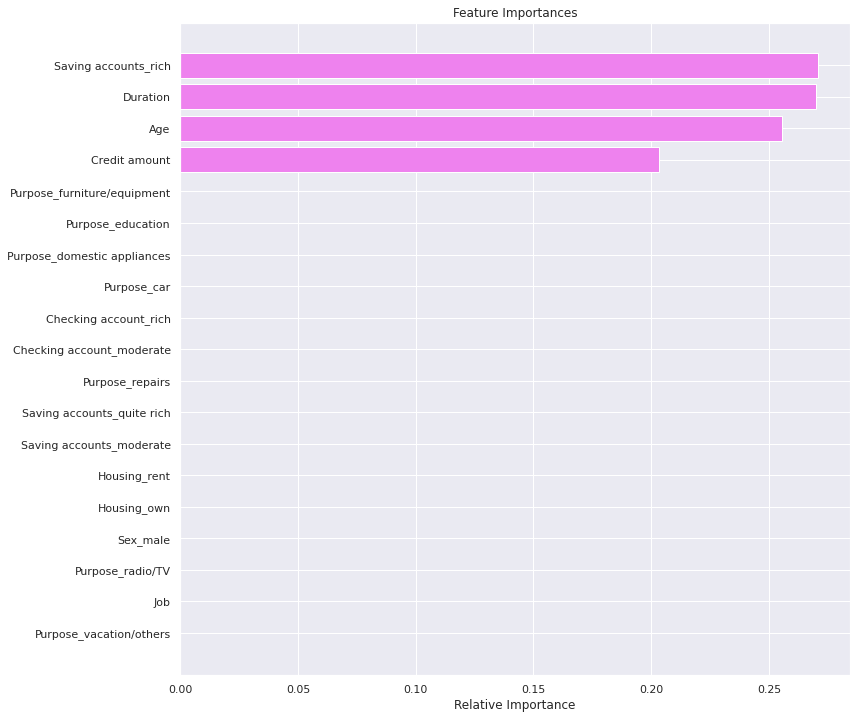

In [ ]:
feature_names = X_train.columns
importances = xgb_tuned1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Savings account and duration are the two most important variables which make sense as these variable play an important role in taking/returning credit.

## Pipelines for productionizing the model
- Now, we have a final model. let's use pipelines to put the model into production



## Column Transformer
- We know that we can use pipelines to standardize the model building, but the steps in a pipeline are applied to each and every variable - how can we personalize the pipeline to perform different processing on different columns
- Column transformer allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

- We will create 2 different pipelines, one for numerical columns and one for categorical columns
- For numerical columns, we will do missing value imputation as pre-processing
- For categorical columns, we will do one hot encoding and missing value imputation as pre-processing

- We are doing missing value imputation for the whole data, so that if there is any missing value in the data in future that can be taken care of.

In [ ]:
# creating a list of numerical variables
numerical_features = ["Age", "Credit amount", "Duration"]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# creating a list of categorical variables
categorical_features = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
]

# creating a transformer for categorical variables, which will first apply simple imputer and
# then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes

In [ ]:
# Separating target variable and other variables
X = data.drop("Risk", axis=1)
Y = data["Risk"]

- Now we already know the best model we need to process with, so we don't need to divide data into 3 parts

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(700, 9) (300, 9)


In [ ]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=50,
                scale_pos_weight=10,
                subsample=0.8,
                learning_rate=0.01,
                gamma=0,
                eval_metric="logloss",
                reg_lambda=5,
                max_depth=1,
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Job', 'Housing',
                              

In [ ]:
# Let's check the performance on test set
Model_test = model_performance_classification_sklearn(model, X_test, y_test)
Model_test

,Accuracy,Recall,Precision,F1
0,0.300,1.000,0.300,0.462


## Conclusion and Insights

- The best test recall is ~84% but the test precision is very low i.e ~32% at the same time. This means that the model is not good at identifying non-defaulter, therefore, the bank can lose many opportunities of giving credit to non-defaulters.   
- The model performance can be improved, especially in terms of precision and the bank can use use the model for new customers once desired level of model performance is achieved.
- We saw in our analysis that customers with a little or moderate amount in saving or checking accounts are more likely to default. The bank can be more strict with their rules or interest rates to compensate for the risk.
- Customers with high credit amounts or who take credit for a longer duration are more likely to default. The bank should be more careful while giving high credit amounts or for a longer duration.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown address, etc. to be able to track them.
- Our analysis showed that younger customers are slightly more likely to default. The bank can alter its policies to suppress this.